In [1]:
import networkx as nx
import random as random
import matplotlib.pyplot as plt
import itertools
import numpy as np
from timeit import default_timer as timer
from math import ceil, floor
import copy
import pandas as pd

from mas_transportation_utils import *

## Index des variables 
G = road graph

SPL = shortest path length

range = perception/domaine de recherche

In [5]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass
    
class UserAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        
        #calcul de la longueur du plus court chemin à l'origine
        self.SPL = nx.shortest_path_length(sma.G, source=self.v_dep, target=self.v_arr)
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass
        
        
        

class RiderAgent(UserAgent):
    def __init__(self, unique_id, v_dep, v_arr, detour_coef, max_wt):
        super().__init__(unique_id, v_dep, v_arr)
             
        #preferences
        self.detour_coef = detour_coef #coef max de détour
        self.max_wt = max_wt #temps d'attente max avant annulation de la demande, coef aussi ?
        self.wt = 0
        self.l_arr_tick = sma.tick + self.SPL + int(self.SPL*detour_coef) '''ajout wt?'''
        #True si agent servi avec un itinéraire prévu sinon Faux
        self.served = False
        
        self.node_range = self.compute_detour_node_range(self.v_dep, self.v_arr, self.l_arr_tick - sma.tick)
        self.wt_radius = self.compute_wt_node_range(self.v_dep)
        
    def compute_wt_node_range(self, source):
        return list(nx.ego_graph(G, source, self.max_wt - self.wt))
        
    def compute_detour_node_range(self, source, target, l_arr):
        #retourne les noeuds présents dans une ellipse
        paths = list(nx.all_simple_paths(sma.G, source=source, target=target, cutoff=l_arr))
        return set([item for sublist in paths for item in sublist])
    
    def evaluate_trip_sharing(trip_share_tuple):
        #on ferai un genre de tuple comme dans le papier Xu et Al. 2020
        #tuple = (conducteur1, conducteur2, noeud de transition)
        # pour la généricité si one hop trip : tuple = (conducteur1, conducteur2=None,trans=None)?
        #puis on calcul la différence entre d.len(trip_base) et d.len(trip_new) etc ?
        '''TODO'''
        pass
        
        
    def update(self):
        #si pas encore servi
        if not self.served:
            self.node_range = self.compute_detour_node_range(self.v_dep, self.v_arr, self.l_arr_tick - sma.tick)
            self.wt_radius = self.compute_wt_node_range(self.v_dep)
                
            ####### Phase d'identification des candidats
            #conducteurs passant par le noeud de départ de r et présent dans son cercle d'attente
            match_start_drivers = set(msd for msd in sma.getTSAs[0].get_drivers_from_node(self.v_dep) if msd.v_r in self.wt_radius)
            
            match_end_drivers = sma.getTSAs[0].get_drivers_from_node(self.v_arr)
            
            #si il n'y a pas de conducteurs dispo au départ ou à l'arriver
            #on ne pourra de toute façon rien faire ce tour si
            if (not match_start_drivers) or (not match_end_drivers):
                self.wt+=1
                return
            #pour l'instant on part du principe que un one_hop_match est meilleur qu'un two_hop_match
            one_hop_matched = match_start_drivers & match_end_drivers
            #si il n'y a pas de one hop match
            if not one_hop_matched:
                two_hop_matched = [] #on ajoutera des tuples du type : (d1, d2, noeud de transition)
                #alors on va chercher si il y a des combinaisons possibles entre les deux sets
                for msd in match_start_drivers:
                    candidate_nodes = sma.getTSAs[0].get_nodes_from_driver(msd) & node_range
                    for candidate_node in candidate_nodes:
                        candidate_drivers = sma.getTSAs[0].get_drivers_from_node(candidate_node) & match_end_drivers
                        for candidate_driver in candidate_drivers :
                            two_hop_matched.append((msd, candidate_driver, candidate_node))
                        '''TODO VERIF TEMPS'''
            ####### Phase de filtrage (contraintes)
            
            ####### Phase de selection (optimisation)
            
            '''Peut être merge les trois phases ?'''
                    
                
            
            else :
                #on a des one_hop match possible
                if len(one_hop_matched) == 1:
                    #on a un seul match, du coup on prends celui là si ok temps
                    '''TODO VERIF TEMPS'''
                    
                    driver = list(one_hop_matched)[0]
                else :
                    '''TODO VERIF TEMPS'''
                    pass
                    #il faut choisir le meilleur 
                    #on fonction de quoi ? TODO (dans un premier temps dist totale supple)
        else:
            '''TODO si servi alors on suit litineraire ? verif noeud de transition pour changement etc'''
            pass
            
    
    def decide(self):
        pass
            
        
class TransportServiceAgent(Agent):
    #tsa : agent blackboard
    def __init__(self, unique_id):
        super().__init__(unique_id)
        self.nodes_to_drivers = dict()
        for node in list(sma.G.nodes):
            self.nodes_to_drivers[node] = set()
        self.drivers_to_nodes = dict()
        
    
     
    def update_driver_data(self, d):
        if d.is_alive == False:
            for node in self.drivers_to_nodes[d]:
                self.nodes_to_drivers[node].remove(d)
            del self.drivers_to_nodes[d]
            
        else :
            node_set = set([item for sublist in d.node_ranges for item in sublist])
            print("node set",node_set)
            print("d nodes ranges",d.node_ranges)
            if d in self.drivers_to_nodes.keys() :
                #noeuds à retirer
                old_nodes = self.drivers_to_nodes[d] - node_set
                #noeuds à ajouter
                new_nodes = node_set - self.drivers_to_nodes[d]

                for old_node in old_nodes:
                    self.nodes_to_drivers[old_node].remove(d)

                for new_node in new_nodes:
                    self.nodes_to_drivers[new_node].add(d)
            else :
                for node in node_set:
                    self.nodes_to_drivers[node].add(d)


            self.drivers_to_nodes[d] = node_set
            
    def get_drivers_from_node(self, node):
        
        return self.nodes_to_drivers[node]
    
    def get_nodes_from_driver(self,driver):
        
        return self.drivers_to_nodes[driver]
    
    def update(self):
        print("nodes to drivers",self.nodes_to_drivers)
        print("drivers to nodes",self.drivers_to_nodes)
        pass
    
    def decide(self):
        pass

SyntaxError: invalid syntax (<ipython-input-5-24eb2f683efb>, line 99)

{2, 3}

In [3]:
class DriverAgent(UserAgent):
    def __init__(self, unique_id, v_dep, v_arr, detour_coef, capacity=3):
        super().__init__(unique_id, v_dep, v_arr)
        self.c = capacity
        self.trip = nx.shortest_path(sma.G, source=self.v_dep, target=self.v_arr)[1:]
        #initialisation de la perception
        self.detour_coef = detour_coef
        self.l_arr_tick = sma.tick + self.SPL + int(self.SPL*detour_coef)
        
        #tableaux du scheduling S
        self.arr = [self.SPL]
        self.ddl = [self.l_arr_tick]
        self.slk = [self.ddl[0]-self.arr[0]]
        
        self.stops = [v_arr] #tableau référençant les noeuds avec arrêts obligatoire 
                             #(noeuds de recup et de dépot des passagers et noeud d'arrivé du conducteur)
        self.capacities = [capacity]
        self.tag_event = False
        
        self.node_ranges = [] #les ellipses
        self.node_ranges.append(self.compute_detour_node_range(self.v_dep, self.v_arr, 
                                                                self.l_arr_tick - sma.tick))
        
    def compute_detour_node_range(self, source, target, l_arr):
        #retourne les noeuds présents dans une ellipse
        paths = list(nx.all_simple_paths(sma.G, source=source, target=target, cutoff=l_arr))
        return set([item for sublist in paths for item in sublist])
        
    def compute_all_detour_node_ranges(self):
        self.node_ranges = []
        self.node_ranges.append(self.compute_detour_node_range(self.v_r, self.stops[0],
                                                           (self.arr[0] - sma.tick) + self.slk[0]))
            
        for i in range(len(self.stops)-1):
            self.node_ranges.append(self.compute_detour_node_range(self.stops[i], self.stops[i+1], 
                                                               (self.arr[i+1] - sma.tick - self.arr[i]) + self.slk[i+1]))
         
        
    def to_string(self):
        print("I am driver",self.unique_id,"- trip:",self.trip)
        
      
    def check_faisability(self, rider, r_v1, r_v2, dl_v1, dl_v2):
        if dl_v1 > self.ddl[-1] or dl_v2 > self.ddl[-1]:
            return False
            
        driver_scope = set([item for sublist in self.node_ranges for item in sublist])
        
        if r_v1 not in driver_scope or r_v2 not in driver_scope:
            return False
        
        
        v1_ellipses_index = [index in index for range(len(driver_scope) if r_v1 in driver_scope[index])]
        v2_ellipses_index = [index in index for range(len(driver_scope) if r_v2 in driver_scope[index])]
                            
        for index in v1_ellipses_index :
            if index == 0:
                new_trip_time = sma.tick + nx.shortest_path_length(sma.G, self.v_r, r_v1) 
                             + nx.shortest_path_length(sma.G, r_v1, self.stops[0])
                
                if new_trip_time <= self.ddl[0] and self.capacities[0] > 0:
                    
                             
                             
                             
            else :
                new_trip_time = self.arr[-1] + nx.shortest_path_length(sma.G, self.v_r, r_v1) 
                             + nx.shortest_path_length(sma.G, r_v1, self.stops[index])
                
                if new_trip_time <= self.ddl[index] and self.capacities[index] > 0:
                             
                             
                             
        return True                
        
        
    def add_rider_to_scheduler(self, rider, r_v1, r_v2, dl_v1, dl_v2):
        '''A terme deviendra surement une verif avant modification, donc avec un return'''
        #on ajoute le passager au scheduler, on met a jour le trip et la capacité
        
        #########checks##############
        if dl_v1 > self.ddl[-1] or dl_v2 > self.ddl[-1]:
            raise Exception("Rider's deadline should be lower than driver's deadline, subject to change")
            
        driver_scope = set([item for sublist in self.node_ranges for item in sublist])
        if r_v1 not in driver_scope or r_v2 not in driver_scope:
            raise Exception("Rider's nodes should be in the driver's scope")
        #############################    
            
        for i in range(len(self.ddl)) :
            if dl_v1 <= self.ddl[i] :
                self.ddl.insert(i, dl_v1)
                self.stops.insert(i, r_v1)
                if i == 0:
                    self.capacities.insert(i, self.c - 1)
                else : 
                    self.capacities.insert(i, self.capacities[i-1]-1)
                for j in range(len(self.ddl[i:])):
                    if dl_v2 <= self.ddl[j] :
                        self.ddl.insert(j, dl_v2)
                        self.stops.insert(j, r_v2)
                        self.capacities.insert(j, self.capacities[i-1]+1)
                        break
                break
                
        #puis on recalcule le chemin le plus court et la marge (skl = slack time)
        
        #pour le premier on se base sur le noeud courant
        self.arr = []
        dif = []
        
        self.arr.append(sma.tick + nx.shortest_path_length(sma.G, self.v_r, self.stops[0]))
        dif.append(self.ddl[0] - self.arr[0])
        
        for i in range(len(self.stops)-1):
            self.arr.append(self.arr[i] + nx.shortest_path_length(sma.G, self.stops[i], self.stops[i+1]))
            dif.append(self.ddl[i+1] - self.arr[i+1])
        
        #calcul marge dépendante des marges suivantes
        self.slk = []
        for i in range(len(dif)):
            self.slk.append(np.min(dif[i:]))
        
        self.tag_event = True
        
        
        
    def update(self) :
        if self.tag_event == True:
            self.compute_all_detour_node_ranges()
            self.trip = nx.shortest_path(sma.G, self.v_r, self.stops[0])[1:]
            self.tag_event = False
        else : 
            self.node_ranges[0] = self.compute_detour_node_range(self.v_r, self.stops[0],
                                                           (self.arr[0] - sma.tick) + self.slk[0])
        
        #le conducteur informe l'agent TSA de sa perception, l'agent blackboard
        #pour le moment un seul TSA, on verra plus tard si on en mets plusieurs
        #il faudra alors pour chaque noeud de la perception identifier le TSA responsable
        sma.getTSAs()[0].update_driver_data(self)
        
    
    def decide(self) : 
        #l'agent bouge
        #si on arrive pas au bout du subtrip, on avance
        if len(self.trip)>1:
            if sma.verbose == True:
                print("Driver",self.unique_id,"move from",self.v_r,"to",self.trip[0])
            self.v_r = self.trip.pop(0)
            
        #sinon il faut determiner si le conducteur est arrivé à destination ou si c'est la fin d'une étape        
        else :
            if self.trip[0] == self.v_arr :
                self.is_alive = False
                sma.getTSAs()[0].update_driver_data(self)
                if sma.verbose == True:
                    print("Driver",self.unique_id,"arrived")
            else :
                if sma.verbose == True:
                    print("Driver",self.unique_id,"move from",self.v_r,"to",self.trip[0])
                self.v_r = self.trip[0]
                self.arr.pop(0)
                self.slk.pop(0)
                self.ddl.pop(0)
                self.capacities.pop(0)
                self.node_ranges.pop(0)
                self.stops.pop(0)
                self.trip = nx.shortest_path(sma.G, self.v_r, self.stops[0])[1:]
            

# SMA
* peut être faire 3 dictionnaires d'agents : 1 avec tout les agents, 1 avec les conducteurs et 1 avec les passagers ?

In [4]:
import random
class SMA:
    def __init__(self, verbose=False):
        self.tick=0
        self.resetTicks()
        
        self.agentTypeIdDict = {}
        self.agentTypeIdDict["drivers"] = []
        self.agentTypeIdDict["riders"] = []
        self.agentTypeIdDict["tsas"] = []
        self.agentTypeIdDict["tgas"] = []
        
        self.agentDict = {}
        
        self.G = None
        self.verbose = verbose

    def resetTicks(self):
        self.tick=0
          
    def setRoadGraph(self,graph):
        self.G = graph
        
    def addAgent(self,ag):
        self.agentDict[ag.unique_id] = ag
        if "RiderAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["riders"].append(ag.unique_id)
        elif "DriverAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["drivers"].append(ag.unique_id)
        elif "TransportServiceAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tsas"].append(ag.unique_id)
        elif "TransportGeneratorAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tgas"].append(ag.unique_id)
        else: raise Exception(ag.__class__.__name__,"is a wrong type of agent.")
            
            
    def getAgentFromId(self, unique_id):
        return self.agentDict[unique_id]
    
    def getRiders(self):
        R = []
        for r in self.agentTypeIdDict['riders']:
            R.append(self.agentDict[r])
        return R
        
    def getDrivers(self):
        D = []
        for d in self.agentTypeIdDict['drivers']:
            D.append(self.agentDict[d])
        return D
        
    def getTSAs(self):
        TSA = []
        for tsa in self.agentTypeIdDict['tsas']:
            TSA.append(self.agentDict[tsa])
        return TSA
    
    def getTGAs(self):
        TGA = []
        for tga in self.agentTypeIdDict['tgas']:
            TGA.append(self.agentDict[tga])
        return TGA
        
 
    def run(self,rounds=None):
        if rounds==None:
            #on s'arrete si tout les passagers ou tout les conducteurs sont arrivés
            self.runOnce()
            while len([agent for agent in sma.agentDict.values() if ("RiderAgent" in agent.__class__.__name__)]) > 0 and len([agent for agent in sma.agentDict.values() if ("DriverAgent" in agent.__class__.__name__)]) > 0:
                self.runOnce()
            #print("Finished in",self.tick,"ticks")
        
        else :
            #génération classique
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentDict.values() :
            print(ag.unique_id)
            ag.update()
            ag.decide()
        
        #phase de nettoyage des agents morts
        for ag in self.agentDict.copy().values():
            if ag.is_alive == False:
                if "RiderAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["riders"].removre(ag.unique_id)
                elif "DriverAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["drivers"].remove(ag.unique_id)
                elif "TransportServiceAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tsas"].remove(ag.unique_id)
                elif "TransportGeneratorAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tgas"].remove(ag.unique_id)
                else: raise Exception(ag.__class__.__name__,"is a wrong type of agent, even if diying.")
                
                self.agentDict.pop(ag.unique_id)
                
                
        if self.verbose == True:      
            print("tick",str(self.tick),"ended")

# ESSAI PERCEPTION

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


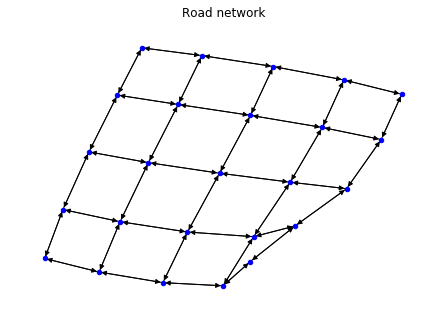

In [31]:
SIZE_MAP = 5
PER_PERTURB_MAP = 0
MAX_NB_DRIVERS = np.arange(5,500,50)
MAX_NB_RIDERS = 100
NB_RUN = 1000
SEED = [1,6,42,69,48,100,26,35,89,663,559,478,452,236,5789,555,666,777,888,999,111,222,333,444,555]
#NB_REP = len(SEED)

#riders_types=['naive','retag','retag_risky']
riders_types=['naive','retag']
results = []

G = generate_2D_graph(SIZE_MAP, coef_suppr=PER_PERTURB_MAP, show=True)

In [72]:
nx.shortest_path_length(G, (0,0), (0,2))


2

In [56]:
sma = SMA()
sma.setRoadGraph(G)
sma.tick = 253
source = (1,0)
target = (3,2)
d1 = DriverAgent(1, source, target, 0.5)

In [57]:
diction = dict()
diction[d1] = 'lol'

In [58]:
d1 in diction.keys()

True

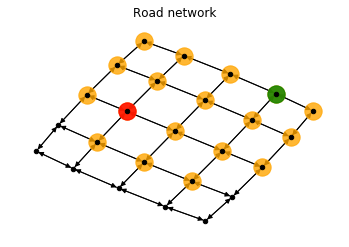

[{(0, 0),
  (0, 1),
  (0, 2),
  (1, 0),
  (1, 1),
  (1, 2),
  (1, 3),
  (2, 0),
  (2, 1),
  (2, 2),
  (2, 3),
  (3, 0),
  (3, 1),
  (3, 2),
  (3, 3),
  (4, 0),
  (4, 1),
  (4, 2)}]

In [59]:
print_user_perception(d1, sma.G)
d1.node_ranges

In [60]:
d1.ddl

[259]

#### Test exception 1

In [61]:
d1.add_rider_to_scheduler(None, (1,1), (1,4), 1, 5)

Exception: Rider's nodes should be in the driver's scope

#### Test exception 2

In [62]:
d1.add_rider_to_scheduler(None, (1,1), (1,4), 1, 3)

Exception: Rider's nodes should be in the driver's scope

#### Ajout d'un passager

In [63]:
d1.add_rider_to_scheduler(None, (1,1), (3,1), 254, 256)
d1.stops

[(1, 1), (3, 1), (3, 2)]

In [64]:
d1.compute_all_detour_node_ranges()

In [65]:
d1.node_ranges


[{(1, 0), (1, 1)}, set(), set()]

In [66]:
d1.slk

[0, 0, 2]

In [67]:
d1.ddl

[254, 256, 259]

In [68]:
d1.arr

[254, 256, 257]

In [ ]:
print_user_perception(d1, sma.G, step_by_step=True)

# ESSAI UPDATE ET DECIDE CONDUCTEUR

In [ ]:
SIZE_MAP = 5
PER_PERTURB_MAP = 0
MAX_NB_DRIVERS = np.arange(5,500,50)
MAX_NB_RIDERS = 100
NB_RUN = 1000
SEED = [1,6,42,69,48,100,26,35,89,663,559,478,452,236,5789,555,666,777,888,999,111,222,333,444,555]
#NB_REP = len(SEED)

#riders_types=['naive','retag','retag_risky']
riders_types=['naive','retag']
results = []

G = generate_2D_graph(SIZE_MAP, coef_suppr=PER_PERTURB_MAP, show=True)

In [ ]:
sma = SMA()
sma.setRoadGraph(G)
source = (1,0)
target = (3,2)
d1 = DriverAgent(1, source, target, 0.5)


In [ ]:
print_user_perception(d1, sma.G)
d1.node_ranges

on a rien changer, si je fais update, je suis sensé avoir la même chose

In [ ]:
d1.update()

In [ ]:
print_user_perception(d1, sma.G)
d1.node_ranges[0]

maintenant, j'ajoute un passager

In [ ]:
d1.add_rider_to_scheduler(None, (1,1), (3,1), 1, 3)
d1.update()
print_user_perception(d1, sma.G, step_by_step=True)
d1.node_ranges[0]
print("trip:",d1.trip)

perception ok, je decide de bouger

In [ ]:
d1.decide()

le conducteur mets à jour ses infos

In [ ]:
d1.update()
print_user_perception(d1, sma.G, step_by_step=True)
d1.node_ranges[0]
print("trip:",d1.trip)

éxécution complète

In [ ]:
sma = SMA()
sma.setRoadGraph(G)
source = (1,0)
target = (3,2)
d1 = DriverAgent(1, source, target, 0.5)
d1.add_rider_to_scheduler(None, (1,1), (3,1), 1, 3)
tick = 0
while d1.is_alive == True :
    print("tick:",tick)
    print("pos",d1.v_r)
    d1.update()
    print_user_perception(d1, sma.G, step_by_step=True)
    d1.decide()
    tick+=1

In [ ]:
#wt range compute example
source = (1,1)
list(nx.ego_graph(G, source, 5))

In [ ]:
paths = list(nx.all_simple_paths(G, source=source, target=target, cutoff=limit_range))
set([item for sublist in paths for item in sublist])

ESSAI AVEC SMA ET TSA

/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/fevrec/Applications/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


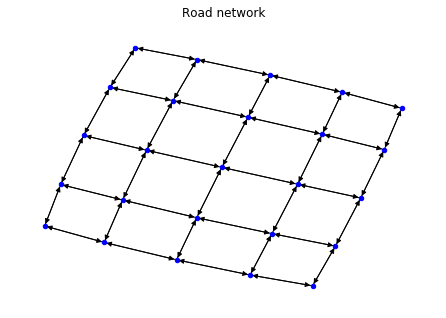

In [7]:
SIZE_MAP = 5
PER_PERTURB_MAP = 0
MAX_NB_DRIVERS = np.arange(5,500,50)
MAX_NB_RIDERS = 100
NB_RUN = 1000
SEED = [1,6,42,69,48,100,26,35,89,663,559,478,452,236,5789,555,666,777,888,999,111,222,333,444,555]
#NB_REP = len(SEED)

#riders_types=['naive','retag','retag_risky']
riders_types=['naive','retag']
results = []

G = generate_2D_graph(SIZE_MAP, coef_suppr=PER_PERTURB_MAP, show=True)

In [8]:
sma = SMA(verbose=True)
sma.setRoadGraph(G)
source = (1,0)
target = (3,2)
d1 = DriverAgent(1, source, target, 1)

tsa1 = TransportServiceAgent(2)
r1 = RiderAgent(3, (1,1), (3,1), 0, 5)

In [ ]:
sma.addAgent(d1)
sma.addAgent(tsa1)
sma.addAgent(r1)
d1.add_rider_to_scheduler(r1,(1,1), (3,1), 1, 4)

In [ ]:
sma.run(10)

In [25]:
d1 = DriverAgent(1, source, target, 1)
d2 = DriverAgent(2, source, target, 6)
d3 = DriverAgent(3, source, target, 4)

In [27]:
a = {d1,d2}
b = {d2,d3}
c = a & b
list(c)[0].to_string()

I am driver 2 - trip: [(2, 0), (3, 0), (3, 1), (3, 2)]
